In [1]:
# anchor. context. [SEP] target. context.

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    exp='000'
    wandb=True
    resume = None  # [None, 'auto', 'always']
    competition='PPPM'
    debug=False  # False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=12  # 16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = '-exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [3]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Tue May 31 23:10:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [4]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
Mounted at /content/drive
     |████████████████████████████████| 58 kB 3.3 MB/s 
CPU times: user 1.04 s, sys: 251 ms, total: 1.29 s
Wall time: 29 s


In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [6]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    !pip install -q wandb
    import wandb

    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        with open('/content/drive/MyDrive/kaggle/wandb') as f:
           wandb_api_key = f.readline().rstrip('\n')
        wandb.login(key=wandb_api_key)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                     name=CFG.exp,
                     config=class2dict(CFG),
                    #  group=CFG.exp,
                     job_type="train",
                     resume=CFG.resume,
                     anonymous=anony)

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 181 kB 62.5 MB/s 
     |████████████████████████████████| 145 kB 66.5 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin


# Library

In [7]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
tqdm.pandas()
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [9]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [10]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [11]:
train['anchor_context'] = train['anchor'] + '[SEP]' + train['context_text']
test['anchor_context'] = test['anchor'] + '[SEP]' + test['context_text']
train['target_context'] = train['target'] + '[SEP]'  + train['context_text']
test['target_context'] = test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,anchor_context,target_context
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]HUMAN NECESSITIES. FURNITURE; DO...,abatement of pollution[SEP]HUMAN NECESSITIES. ...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]HUMAN NECESSITIES. FURNITURE; DO...,act of abating[SEP]HUMAN NECESSITIES. FURNITUR...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]HUMAN NECESSITIES. FURNITURE; DO...,active catalyst[SEP]HUMAN NECESSITIES. FURNITU...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]HUMAN NECESSITIES. FURNITURE; DO...,eliminating process[SEP]HUMAN NECESSITIES. FUR...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]HUMAN NECESSITIES. FURNITURE; DO...,forest region[SEP]HUMAN NECESSITIES. FURNITURE...


,id,anchor,target,context,context_text,anchor_context,target_context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]PHYSICS. OPTICS,inorganic photoconductor drum[SEP]PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]MECHANICAL ENGINEERING; LI...,altering gas flow[SEP]MECHANICAL ENGINEERING; ...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]PERFORMING OPERATIONS; TRAN...,lower locating[SEP]PERFORMING OPERATIONS; TRAN...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]TEXTILES; PAPER. TREATMENT O...,upper portion[SEP]TEXTILES; PAPER. TREATMENT O...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]ELECTRICITY. ELECTRIC C...,artificial neural network[SEP]ELECTRICITY. ELE...


# EDA

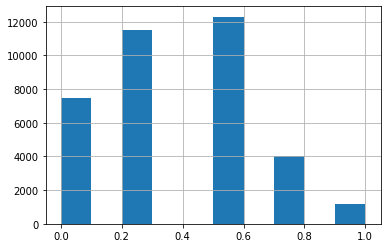

In [12]:
train['score'].hist()

In [13]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [14]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [15]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [16]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [17]:
# ====================================================
# Define max_len
# ====================================================
# lengths_dict = {}

# lengths = []
# tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
# for text in tk0:
#     length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
#     lengths.append(length)
# lengths_dict['context_text'] = lengths

# for text_col in ['anchor', 'target']:
#     lengths = []
#     tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
#     for text in tk0:
#         length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
#         lengths.append(length)
#     lengths_dict[text_col] = lengths
    
# CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
#                 + max(lengths_dict['context_text'])*2 + 5 # CLS + SEP + SEP + SEP + SEP

train['len'] = train.progress_apply(lambda row: len(CFG.tokenizer(row['anchor_context'], row['target_context'], add_special_tokens=True)['input_ids']), axis=1)
CFG.max_len = train['len'].max()

LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 187


In [18]:
train['len'].describe()

count    36473.000000
mean        47.604831
std         25.239059
min         17.000000
25%         28.000000
50%         41.000000
75%         63.000000
max        187.000000
Name: len, dtype: float64

In [19]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, anchor, target):
    inputs = cfg.tokenizer(anchor, target,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.anchor = df['anchor_context'].values
        self.target = df['target_context'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.anchor[item], self.target[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [20]:
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)

{'input_ids': tensor([     1,  47284,      2,  54373,  24817,  37360,  50787,    260, 114347,
           346,  34093,  17808,  12713,  66582,    430,   3516,  24093,  58629,
        110304,    346,  94252, 108812,    346, 104775, 108812,    346,  20143,
        100168,  46465,  12921,   3078,  43799,      2,  47284,    265,   6435,
             2,  54373,  24817,  37360,  50787,    260, 114347,    346,  34093,
         17808,  12713,  66582,    430,   3516,  24093,  58629, 110304,    346,
         94252, 108812,    346, 104775, 108812,    346,  20143, 100168,  46465,
         12921,   3078,  43799,      2,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,   

# Model

In [21]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [22]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [23]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    if wandb.run.resumed:
        checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['model'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        # amp.load_state_dict(checkpoint['amp'])
        epoch = checkpoint['epoeh'] + 1  # 保存時のエポックが読み出されるので+1
        best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        torch.save({'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                    # 'amp': amp.state_dict(),
                    'epoch': epoch,
                    'best_score': best_score},
                    checkpoint_path)
        # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [24]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'oof.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            torch.save({'fold': fold,
                        'oof_df': oof_df},
                        OUTPUT_DIR + 'oof.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2257] Elapsed 0m 1s (remain 50m 48s) Loss: 0.6695(0.6695) Grad: 197205.0312  LR: 0.00002000  
Epoch: [1][100/2257] Elapsed 1m 42s (remain 36m 20s) Loss: 0.6232(0.6508) Grad: 34738.5234  LR: 0.00001999  
Epoch: [1][200/2257] Elapsed 3m 22s (remain 34m 33s) Loss: 0.6679(0.6264) Grad: 58895.0820  LR: 0.00001998  
Epoch: [1][300/2257] Elapsed 5m 3s (remain 32m 50s) Loss: 0.6468(0.6159) Grad: 126927.8359  LR: 0.00001995  
Epoch: [1][400/2257] Elapsed 6m 43s (remain 31m 9s) Loss: 0.5796(0.6070) Grad: 26567.1875  LR: 0.00001990  
Epoch: [1][500/2257] Elapsed 8m 24s (remain 29m 27s) Loss: 0.6139(0.6018) Grad: 23003.7480  LR: 0.00001985  
Epoch: [1][600/2257] Elapsed 10m 5s (remain 27m 47s) Loss: 0.5697(0.5958) Grad: 39185.6055  LR: 0.00001978  
Epoch: [1][700/2257] Elapsed 11m 45s (remain 26m 6s) Loss: 0.5744(0.5901) Grad: 29306.1992  LR: 0.00001970  
Epoch: [1][800/2257] Elapsed 13m 26s (remain 24m 25s) Loss: 0.6484(0.5845) Grad: 21814.6484  LR: 0.00001961  
Epoch: [1][900/2257] 

Epoch 1 - avg_train_loss: 0.5613  avg_val_loss: 0.5509  time: 2511s
Epoch 1 - Score: 0.8183


EVAL: [781/782] Elapsed 3m 59s (remain 0m 0s) Loss: 0.6987(0.5509) 


Epoch 1 - Save Best Score: 0.8183 Model


Epoch: [2][0/2257] Elapsed 0m 1s (remain 61m 13s) Loss: 0.5691(0.5691) Grad: 83006.2344  LR: 0.00001707  
Epoch: [2][100/2257] Elapsed 1m 44s (remain 37m 5s) Loss: 0.5818(0.5146) Grad: 66465.6875  LR: 0.00001682  
Epoch: [2][200/2257] Elapsed 3m 24s (remain 34m 55s) Loss: 0.5825(0.5215) Grad: 56435.5859  LR: 0.00001656  
Epoch: [2][300/2257] Elapsed 5m 5s (remain 33m 4s) Loss: 0.4411(0.5186) Grad: 134880.0781  LR: 0.00001630  
Epoch: [2][400/2257] Elapsed 6m 45s (remain 31m 19s) Loss: 0.4864(0.5175) Grad: 73625.1953  LR: 0.00001602  
Epoch: [2][500/2257] Elapsed 8m 26s (remain 29m 35s) Loss: 0.4940(0.5187) Grad: 52511.5820  LR: 0.00001574  
Epoch: [2][600/2257] Elapsed 10m 7s (remain 27m 52s) Loss: 0.6003(0.5165) Grad: 444456.7500  LR: 0.00001545  
Epoch: [2][700/2257] Elapsed 11m 47s (remain 26m 10s) Loss: 0.6165(0.5160) Grad: 79559.4297  LR: 0.00001516  
Epoch: [2][800/2257] Elapsed 13m 28s (remain 24m 30s) Loss: 0.4562(0.5157) Grad: 144620.1094  LR: 0.00001486  
Epoch: [2][900/2257]

Epoch 2 - avg_train_loss: 0.5159  avg_val_loss: 0.5549  time: 2513s
Epoch 2 - Score: 0.8306


EVAL: [781/782] Elapsed 3m 59s (remain 0m 0s) Loss: 0.6984(0.5549) 


Epoch 2 - Save Best Score: 0.8306 Model


Epoch: [3][0/2257] Elapsed 0m 1s (remain 53m 55s) Loss: 0.5022(0.5022) Grad: 48400.3359  LR: 0.00001000  
Epoch: [3][100/2257] Elapsed 1m 43s (remain 36m 40s) Loss: 0.5185(0.5006) Grad: 89520.8906  LR: 0.00000965  
Epoch: [3][200/2257] Elapsed 3m 23s (remain 34m 44s) Loss: 0.4369(0.4987) Grad: 48456.6641  LR: 0.00000931  
Epoch: [3][300/2257] Elapsed 5m 4s (remain 32m 56s) Loss: 0.5842(0.4986) Grad: 55585.0039  LR: 0.00000896  
Epoch: [3][400/2257] Elapsed 6m 44s (remain 31m 13s) Loss: 0.4883(0.4993) Grad: 46610.3086  LR: 0.00000861  
Epoch: [3][500/2257] Elapsed 8m 25s (remain 29m 30s) Loss: 0.4927(0.4998) Grad: 46126.0586  LR: 0.00000827  
Epoch: [3][600/2257] Elapsed 10m 5s (remain 27m 49s) Loss: 0.4806(0.5004) Grad: 55583.0000  LR: 0.00000793  
Epoch: [3][700/2257] Elapsed 11m 46s (remain 26m 7s) Loss: 0.4101(0.4991) Grad: 15456.6455  LR: 0.00000759  
Epoch: [3][800/2257] Elapsed 13m 26s (remain 24m 26s) Loss: 0.5019(0.5012) Grad: 58791.4609  LR: 0.00000725  
Epoch: [3][900/2257] E

Epoch 3 - avg_train_loss: 0.5040  avg_val_loss: 0.5649  time: 2511s
Epoch 3 - Score: 0.8327


EVAL: [781/782] Elapsed 3m 59s (remain 0m 0s) Loss: 0.6976(0.5649) 


Epoch 3 - Save Best Score: 0.8327 Model


Epoch: [4][0/2257] Elapsed 0m 1s (remain 57m 5s) Loss: 0.3513(0.3513) Grad: 9841.2871  LR: 0.00000293  
Epoch: [4][100/2257] Elapsed 1m 43s (remain 36m 45s) Loss: 0.5089(0.5028) Grad: 42412.2656  LR: 0.00000269  
Epoch: [4][200/2257] Elapsed 3m 23s (remain 34m 46s) Loss: 0.5004(0.4998) Grad: 52106.7070  LR: 0.00000246  
Epoch: [4][300/2257] Elapsed 5m 4s (remain 32m 59s) Loss: 0.4606(0.4987) Grad: 63594.3359  LR: 0.00000223  
Epoch: [4][400/2257] Elapsed 6m 45s (remain 31m 15s) Loss: 0.5354(0.4995) Grad: 38110.5977  LR: 0.00000202  
Epoch: [4][500/2257] Elapsed 8m 25s (remain 29m 33s) Loss: 0.6409(0.4971) Grad: 53754.6211  LR: 0.00000181  
Epoch: [4][600/2257] Elapsed 10m 6s (remain 27m 51s) Loss: 0.4338(0.4964) Grad: 37851.2812  LR: 0.00000162  
Epoch: [4][700/2257] Elapsed 11m 47s (remain 26m 9s) Loss: 0.4563(0.4981) Grad: 407813.4688  LR: 0.00000143  
Epoch: [4][800/2257] Elapsed 13m 27s (remain 24m 28s) Loss: 0.6202(0.4970) Grad: 19199.8047  LR: 0.00000126  
Epoch: [4][900/2257] El

Epoch 4 - avg_train_loss: 0.4959  avg_val_loss: 0.5727  time: 2511s
Epoch 4 - Score: 0.8311


EVAL: [781/782] Elapsed 3m 59s (remain 0m 0s) Loss: 0.6921(0.5727) 


========== fold: 0 result ==========
Score: 0.8327
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2301] Elapsed 0m 1s (remain 54m 48s) Loss: 0.7654(0.7654) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2301] Elapsed 1m 42s (remain 37m 18s) Loss: 0.6808(0.6528) Grad: 25101.3711  LR: 0.00001999  
Epoch: [1][200/2301] Elapsed 3m 23s (remain 35m 25s) Loss: 0.5428(0.6252) Grad: 36266.0781  LR: 0.00001998  
Epoch: [1][300/2301] Elapsed 5m 4s (remain 33m 40s) Loss: 0.5214(0.6108) Grad: 32244.2910  LR: 0.00001995  
Epoch: [1][400/2301] Elapsed 6m 44s (remain 31m 58s) Loss: 0.6074(0.5988) Grad: 20871.2988  LR: 0.00001991  
Epoch: [1][500/2301] Elapsed 8m 25s (remain 30m 15s) Loss: 0.4854(0.5915) Grad: 57350.2969  LR: 0.00001985  
Epoch: [1][600/2301] Elapsed 10m 5s (remain 28m 34s) Loss: 0.5830(0.5864) Grad: 35990.3008  LR: 0.00001979  
Epoch: [1][700/2301] Elapsed 11m 46s (remain 26m 52s) Loss: 0.4667(0.5823) Grad: 23469.8613  LR: 0.00001972  
Epoch: [1][800/2301] Elapsed 13m 27s (remain 25m 11s) Loss: 0.4928(0.5797) Grad: 21820.6875  LR: 0.00001963  
Epoch: [1][900/2301] Elapsed

Epoch 1 - avg_train_loss: 0.5581  avg_val_loss: 0.5579  time: 2542s
Epoch 1 - Score: 0.8049


EVAL: [738/739] Elapsed 3m 45s (remain 0m 0s) Loss: 0.6696(0.5579) 


Epoch 1 - Save Best Score: 0.8049 Model


Epoch: [2][0/2301] Elapsed 0m 1s (remain 62m 56s) Loss: 0.5097(0.5097) Grad: 49436.1797  LR: 0.00001707  
Epoch: [2][100/2301] Elapsed 1m 44s (remain 37m 57s) Loss: 0.5408(0.5188) Grad: 42935.4844  LR: 0.00001682  
Epoch: [2][200/2301] Elapsed 3m 25s (remain 35m 44s) Loss: 0.5536(0.5261) Grad: 157380.9688  LR: 0.00001657  
Epoch: [2][300/2301] Elapsed 5m 5s (remain 33m 52s) Loss: 0.4371(0.5241) Grad: 73945.2266  LR: 0.00001631  
Epoch: [2][400/2301] Elapsed 6m 46s (remain 32m 7s) Loss: 0.5247(0.5231) Grad: 83635.4062  LR: 0.00001604  
Epoch: [2][500/2301] Elapsed 8m 27s (remain 30m 22s) Loss: 0.6045(0.5212) Grad: 37240.9961  LR: 0.00001576  
Epoch: [2][600/2301] Elapsed 10m 7s (remain 28m 39s) Loss: 0.6827(0.5188) Grad: 234217.8750  LR: 0.00001548  
Epoch: [2][700/2301] Elapsed 11m 48s (remain 26m 57s) Loss: 0.4672(0.5185) Grad: 48747.5039  LR: 0.00001519  
Epoch: [2][800/2301] Elapsed 13m 29s (remain 25m 15s) Loss: 0.3815(0.5172) Grad: 404622.7500  LR: 0.00001490  
Epoch: [2][900/2301

Epoch 2 - avg_train_loss: 0.5177  avg_val_loss: 0.5791  time: 2546s
Epoch 2 - Score: 0.8042


EVAL: [738/739] Elapsed 3m 46s (remain 0m 0s) Loss: 0.6697(0.5791) 
Epoch: [3][0/2301] Elapsed 0m 1s (remain 48m 14s) Loss: 0.4793(0.4793) Grad: 47916.9023  LR: 0.00001000  
Epoch: [3][100/2301] Elapsed 1m 43s (remain 37m 27s) Loss: 0.6459(0.5137) Grad: 127645.2031  LR: 0.00000966  
Epoch: [3][200/2301] Elapsed 3m 23s (remain 35m 29s) Loss: 0.4305(0.5134) Grad: 180913.9688  LR: 0.00000931  
Epoch: [3][300/2301] Elapsed 5m 4s (remain 33m 45s) Loss: 0.5095(0.5140) Grad: 42966.4531  LR: 0.00000897  
Epoch: [3][400/2301] Elapsed 6m 45s (remain 32m 0s) Loss: 0.5137(0.5129) Grad: 36912.4648  LR: 0.00000864  
Epoch: [3][500/2301] Elapsed 8m 26s (remain 30m 18s) Loss: 0.5537(0.5146) Grad: 41190.2734  LR: 0.00000830  
Epoch: [3][600/2301] Elapsed 10m 6s (remain 28m 36s) Loss: 0.5171(0.5143) Grad: 35912.2578  LR: 0.00000796  
Epoch: [3][700/2301] Elapsed 11m 47s (remain 26m 55s) Loss: 0.6391(0.5100) Grad: 14264.0918  LR: 0.00000763  
Epoch: [3][800/2301] Elapsed 13m 28s (remain 25m 13s) Loss: 0.

Epoch 3 - avg_train_loss: 0.5043  avg_val_loss: 0.5726  time: 2545s
Epoch 3 - Score: 0.8155


EVAL: [738/739] Elapsed 3m 45s (remain 0m 0s) Loss: 0.6660(0.5726) 


Epoch 3 - Save Best Score: 0.8155 Model


Epoch: [4][0/2301] Elapsed 0m 1s (remain 63m 39s) Loss: 0.4903(0.4903) Grad: 34016.4102  LR: 0.00000293  
Epoch: [4][100/2301] Elapsed 1m 44s (remain 37m 46s) Loss: 0.5277(0.4908) Grad: 61906.1523  LR: 0.00000269  
Epoch: [4][200/2301] Elapsed 3m 24s (remain 35m 37s) Loss: 0.4437(0.5040) Grad: 15007.2559  LR: 0.00000246  
Epoch: [4][300/2301] Elapsed 5m 5s (remain 33m 48s) Loss: 0.5964(0.4966) Grad: 509688.8125  LR: 0.00000224  
Epoch: [4][400/2301] Elapsed 6m 46s (remain 32m 3s) Loss: 0.5466(0.4980) Grad: 37151.8633  LR: 0.00000203  
Epoch: [4][500/2301] Elapsed 8m 26s (remain 30m 21s) Loss: 0.5472(0.4985) Grad: 35087.5938  LR: 0.00000183  
Epoch: [4][600/2301] Elapsed 10m 7s (remain 28m 38s) Loss: 0.4325(0.5000) Grad: 294813.8125  LR: 0.00000164  
Epoch: [4][700/2301] Elapsed 11m 48s (remain 26m 56s) Loss: 0.5076(0.4988) Grad: 31132.9375  LR: 0.00000145  
Epoch: [4][800/2301] Elapsed 13m 28s (remain 25m 14s) Loss: 0.4476(0.4990) Grad: 92763.2734  LR: 0.00000128  
Epoch: [4][900/2301]

Epoch 4 - avg_train_loss: 0.4951  avg_val_loss: 0.5788  time: 2545s
Epoch 4 - Score: 0.8152


EVAL: [738/739] Elapsed 3m 45s (remain 0m 0s) Loss: 0.6688(0.5788) 


========== fold: 1 result ==========
Score: 0.8155
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2321] Elapsed 0m 1s (remain 59m 24s) Loss: 0.6872(0.6872) Grad: 128028.3828  LR: 0.00002000  
Epoch: [1][100/2321] Elapsed 1m 43s (remain 37m 50s) Loss: 0.6651(0.6559) Grad: 81710.8125  LR: 0.00001999  
Epoch: [1][200/2321] Elapsed 3m 23s (remain 35m 49s) Loss: 0.5291(0.6263) Grad: 115379.4219  LR: 0.00001998  
Epoch: [1][300/2321] Elapsed 5m 4s (remain 34m 3s) Loss: 0.4256(0.6057) Grad: 25876.5703  LR: 0.00001995  
Epoch: [1][400/2321] Elapsed 6m 45s (remain 32m 19s) Loss: 0.6277(0.5993) Grad: 43148.6797  LR: 0.00001991  
Epoch: [1][500/2321] Elapsed 8m 25s (remain 30m 36s) Loss: 0.5116(0.5924) Grad: 81616.3906  LR: 0.00001986  
Epoch: [1][600/2321] Elapsed 10m 6s (remain 28m 55s) Loss: 0.6838(0.5901) Grad: 90080.5547  LR: 0.00001979  
Epoch: [1][700/2321] Elapsed 11m 47s (remain 27m 13s) Loss: 0.5950(0.5861) Grad: 69893.2891  LR: 0.00001972  
Epoch: [1][800/2321] Elapsed 13m 27s (remain 25m 32s) Loss: 0.5413(0.5828) Grad: 13591.1455  LR: 0.00001964  
Epoch: [1][900/2321]

Epoch 1 - avg_train_loss: 0.5617  avg_val_loss: 0.5404  time: 2557s
Epoch 1 - Score: 0.8265


EVAL: [717/718] Elapsed 3m 39s (remain 0m 0s) Loss: 0.5646(0.5404) 


Epoch 1 - Save Best Score: 0.8265 Model


Epoch: [2][0/2321] Elapsed 0m 1s (remain 63m 42s) Loss: 0.3296(0.3296) Grad: 41881.0352  LR: 0.00001707  
Epoch: [2][100/2321] Elapsed 1m 44s (remain 38m 27s) Loss: 0.5732(0.5218) Grad: 26803.3438  LR: 0.00001683  
Epoch: [2][200/2321] Elapsed 3m 25s (remain 36m 8s) Loss: 0.6386(0.5203) Grad: 101947.5625  LR: 0.00001658  
Epoch: [2][300/2321] Elapsed 5m 6s (remain 34m 15s) Loss: 0.4688(0.5163) Grad: 88588.8906  LR: 0.00001632  
Epoch: [2][400/2321] Elapsed 6m 46s (remain 32m 28s) Loss: 0.4840(0.5146) Grad: 112958.3047  LR: 0.00001605  
Epoch: [2][500/2321] Elapsed 8m 27s (remain 30m 43s) Loss: 0.4617(0.5127) Grad: 101177.0938  LR: 0.00001578  
Epoch: [2][600/2321] Elapsed 10m 8s (remain 29m 0s) Loss: 0.5870(0.5135) Grad: 190820.8125  LR: 0.00001550  
Epoch: [2][700/2321] Elapsed 11m 48s (remain 27m 18s) Loss: 0.4715(0.5128) Grad: 147734.1094  LR: 0.00001521  
Epoch: [2][800/2321] Elapsed 13m 29s (remain 25m 35s) Loss: 0.7589(0.5128) Grad: 240722.2812  LR: 0.00001492  
Epoch: [2][900/23

Epoch 2 - avg_train_loss: 0.5181  avg_val_loss: 0.5424  time: 2559s
Epoch 2 - Score: 0.8412


EVAL: [717/718] Elapsed 3m 39s (remain 0m 0s) Loss: 0.5596(0.5424) 


Epoch 2 - Save Best Score: 0.8412 Model


Epoch: [3][0/2321] Elapsed 0m 1s (remain 58m 22s) Loss: 0.6464(0.6464) Grad: 39326.0312  LR: 0.00001000  
Epoch: [3][100/2321] Elapsed 1m 43s (remain 37m 57s) Loss: 0.5129(0.5038) Grad: 52446.9258  LR: 0.00000966  
Epoch: [3][200/2321] Elapsed 3m 24s (remain 35m 56s) Loss: 0.5433(0.5021) Grad: 289233.2188  LR: 0.00000933  
Epoch: [3][300/2321] Elapsed 5m 5s (remain 34m 7s) Loss: 0.7256(0.5004) Grad: 727438.3750  LR: 0.00000899  
Epoch: [3][400/2321] Elapsed 6m 45s (remain 32m 22s) Loss: 0.4509(0.4972) Grad: 91949.1250  LR: 0.00000865  
Epoch: [3][500/2321] Elapsed 8m 26s (remain 30m 38s) Loss: 0.6435(0.4985) Grad: 137783.0000  LR: 0.00000832  
Epoch: [3][600/2321] Elapsed 10m 6s (remain 28m 56s) Loss: 0.5012(0.4975) Grad: 32390.3281  LR: 0.00000799  
Epoch: [3][700/2321] Elapsed 11m 47s (remain 27m 15s) Loss: 0.5303(0.5002) Grad: 12550.8486  LR: 0.00000766  
Epoch: [3][800/2321] Elapsed 13m 28s (remain 25m 33s) Loss: 0.5209(0.5010) Grad: 30045.4238  LR: 0.00000733  
Epoch: [3][900/2321

Epoch 3 - avg_train_loss: 0.5075  avg_val_loss: 0.5565  time: 2557s
Epoch 3 - Score: 0.8390


EVAL: [717/718] Elapsed 3m 39s (remain 0m 0s) Loss: 0.5624(0.5565) 
Epoch: [4][0/2321] Elapsed 0m 1s (remain 50m 7s) Loss: 0.4147(0.4147) Grad: 42340.2852  LR: 0.00000293  
Epoch: [4][100/2321] Elapsed 1m 43s (remain 37m 45s) Loss: 0.5194(0.4892) Grad: 76707.9062  LR: 0.00000270  
Epoch: [4][200/2321] Elapsed 3m 23s (remain 35m 47s) Loss: 0.3726(0.4909) Grad: 93812.6250  LR: 0.00000247  
Epoch: [4][300/2321] Elapsed 5m 4s (remain 34m 1s) Loss: 0.5677(0.4937) Grad: 72490.3047  LR: 0.00000225  
Epoch: [4][400/2321] Elapsed 6m 45s (remain 32m 19s) Loss: 0.6015(0.4946) Grad: 26377.9844  LR: 0.00000204  
Epoch: [4][500/2321] Elapsed 8m 25s (remain 30m 37s) Loss: 0.6575(0.4967) Grad: 56780.0586  LR: 0.00000184  
Epoch: [4][600/2321] Elapsed 10m 6s (remain 28m 55s) Loss: 0.3937(0.4950) Grad: 31096.5977  LR: 0.00000165  
Epoch: [4][700/2321] Elapsed 11m 47s (remain 27m 14s) Loss: 0.4358(0.4945) Grad: 30374.3242  LR: 0.00000147  
Epoch: [4][800/2321] Elapsed 13m 27s (remain 25m 32s) Loss: 0.547

Epoch 4 - avg_train_loss: 0.4975  avg_val_loss: 0.5593  time: 2557s
Epoch 4 - Score: 0.8384


EVAL: [717/718] Elapsed 3m 39s (remain 0m 0s) Loss: 0.5376(0.5593) 


========== fold: 2 result ==========
Score: 0.8412
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2237] Elapsed 0m 1s (remain 56m 54s) Loss: 0.7672(0.7672) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2237] Elapsed 1m 43s (remain 36m 18s) Loss: 0.6805(0.6631) Grad: 40822.2461  LR: 0.00001999  
Epoch: [1][200/2237] Elapsed 3m 23s (remain 34m 23s) Loss: 0.4670(0.6291) Grad: 36088.8867  LR: 0.00001998  
Epoch: [1][300/2237] Elapsed 5m 4s (remain 32m 37s) Loss: 0.5402(0.6095) Grad: 47428.1602  LR: 0.00001994  
Epoch: [1][400/2237] Elapsed 6m 44s (remain 30m 54s) Loss: 0.6622(0.5966) Grad: 37830.3125  LR: 0.00001990  
Epoch: [1][500/2237] Elapsed 8m 25s (remain 29m 11s) Loss: 0.4623(0.5920) Grad: 29688.6699  LR: 0.00001985  
Epoch: [1][600/2237] Elapsed 10m 6s (remain 27m 30s) Loss: 0.6145(0.5867) Grad: 28256.5117  LR: 0.00001978  
Epoch: [1][700/2237] Elapsed 11m 46s (remain 25m 48s) Loss: 0.6030(0.5839) Grad: 33814.9922  LR: 0.00001970  
Epoch: [1][800/2237] Elapsed 13m 27s (remain 24m 7s) Loss: 0.5849(0.5796) Grad: 15857.7344  LR: 0.00001961  
Epoch: [1][900/2237] Elapsed 

Epoch 1 - avg_train_loss: 0.5591  avg_val_loss: 0.5562  time: 2499s
Epoch 1 - Score: 0.7993


EVAL: [801/802] Elapsed 4m 5s (remain 0m 0s) Loss: 0.4116(0.5562) 


Epoch 1 - Save Best Score: 0.7993 Model


Epoch: [2][0/2237] Elapsed 0m 1s (remain 51m 39s) Loss: 0.4073(0.4073) Grad: 22258.9902  LR: 0.00001707  
Epoch: [2][100/2237] Elapsed 1m 43s (remain 36m 36s) Loss: 0.6732(0.5215) Grad: 697908.6875  LR: 0.00001682  
Epoch: [2][200/2237] Elapsed 3m 24s (remain 34m 34s) Loss: 0.5914(0.5181) Grad: 54577.5625  LR: 0.00001656  
Epoch: [2][300/2237] Elapsed 5m 5s (remain 32m 44s) Loss: 0.3606(0.5126) Grad: 65821.8750  LR: 0.00001629  
Epoch: [2][400/2237] Elapsed 6m 46s (remain 30m 59s) Loss: 0.5790(0.5146) Grad: 138636.3906  LR: 0.00001601  
Epoch: [2][500/2237] Elapsed 8m 26s (remain 29m 15s) Loss: 0.5169(0.5145) Grad: 47292.8672  LR: 0.00001573  
Epoch: [2][600/2237] Elapsed 10m 7s (remain 27m 33s) Loss: 0.5554(0.5150) Grad: 153916.5312  LR: 0.00001544  
Epoch: [2][700/2237] Elapsed 11m 47s (remain 25m 51s) Loss: 0.4856(0.5155) Grad: 50940.5039  LR: 0.00001514  
Epoch: [2][800/2237] Elapsed 13m 28s (remain 24m 9s) Loss: 0.6122(0.5154) Grad: 49316.5898  LR: 0.00001483  
Epoch: [2][900/2237

Epoch 2 - avg_train_loss: 0.5172  avg_val_loss: 0.5566  time: 2499s
Epoch 2 - Score: 0.8106


EVAL: [801/802] Elapsed 4m 5s (remain 0m 0s) Loss: 0.4206(0.5566) 


Epoch 2 - Save Best Score: 0.8106 Model


Epoch: [3][0/2237] Elapsed 0m 1s (remain 51m 43s) Loss: 0.5478(0.5478) Grad: 75887.2812  LR: 0.00001000  
Epoch: [3][100/2237] Elapsed 1m 43s (remain 36m 22s) Loss: 0.4878(0.5035) Grad: 334383.6875  LR: 0.00000965  
Epoch: [3][200/2237] Elapsed 3m 24s (remain 34m 26s) Loss: 0.5154(0.5088) Grad: 90232.7969  LR: 0.00000930  
Epoch: [3][300/2237] Elapsed 5m 4s (remain 32m 39s) Loss: 0.5128(0.5046) Grad: 52792.4219  LR: 0.00000895  
Epoch: [3][400/2237] Elapsed 6m 45s (remain 30m 57s) Loss: 0.5746(0.5036) Grad: 57705.0195  LR: 0.00000860  
Epoch: [3][500/2237] Elapsed 8m 26s (remain 29m 14s) Loss: 0.4788(0.5031) Grad: 166399.7969  LR: 0.00000825  
Epoch: [3][600/2237] Elapsed 10m 7s (remain 27m 32s) Loss: 0.4010(0.5031) Grad: 114072.7344  LR: 0.00000791  
Epoch: [3][700/2237] Elapsed 11m 47s (remain 25m 50s) Loss: 0.4691(0.5043) Grad: 175917.5312  LR: 0.00000757  
Epoch: [3][800/2237] Elapsed 13m 28s (remain 24m 9s) Loss: 0.4419(0.5032) Grad: 70725.0469  LR: 0.00000723  
Epoch: [3][900/223

Epoch 3 - avg_train_loss: 0.5050  avg_val_loss: 0.5776  time: 2500s
Epoch 3 - Score: 0.8043


EVAL: [801/802] Elapsed 4m 5s (remain 0m 0s) Loss: 0.4086(0.5776) 
Epoch: [4][0/2237] Elapsed 0m 1s (remain 48m 39s) Loss: 0.5931(0.5931) Grad: 87828.4219  LR: 0.00000293  
Epoch: [4][100/2237] Elapsed 1m 42s (remain 36m 16s) Loss: 0.5069(0.5066) Grad: 29253.6621  LR: 0.00000269  
Epoch: [4][200/2237] Elapsed 3m 23s (remain 34m 20s) Loss: 0.5190(0.5043) Grad: 49904.4375  LR: 0.00000245  
Epoch: [4][300/2237] Elapsed 5m 4s (remain 32m 36s) Loss: 0.3671(0.5001) Grad: 90367.9688  LR: 0.00000223  
Epoch: [4][400/2237] Elapsed 6m 44s (remain 30m 53s) Loss: 0.5062(0.5001) Grad: 45090.1562  LR: 0.00000201  
Epoch: [4][500/2237] Elapsed 8m 25s (remain 29m 11s) Loss: 0.4926(0.4995) Grad: 70256.7734  LR: 0.00000180  
Epoch: [4][600/2237] Elapsed 10m 6s (remain 27m 30s) Loss: 0.4628(0.4974) Grad: 149991.1875  LR: 0.00000161  
Epoch: [4][700/2237] Elapsed 11m 47s (remain 25m 49s) Loss: 0.5928(0.4965) Grad: 77888.8828  LR: 0.00000142  
Epoch: [4][800/2237] Elapsed 13m 27s (remain 24m 8s) Loss: 0.48

Epoch 4 - avg_train_loss: 0.4975  avg_val_loss: 0.5806  time: 2500s
Epoch 4 - Score: 0.8043


EVAL: [801/802] Elapsed 4m 5s (remain 0m 0s) Loss: 0.4057(0.5806) 


========== fold: 3 result ==========
Score: 0.8106
========== CV ==========
Score: 0.8235


[fold0] avg_train_loss,█▃▂▁
[fold0] avg_val_loss,▁▂▅█
[fold0] epoch,▁▃▆█
[fold0] loss,▆▇▆█▆▆▅▄▅▅▅▆▇▁█▆▄▆▅▆▅▇▅▅▂▅▄▇▂█▂▅▃█▅▅▇▅▄▅
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▇█▇
[fold1] avg_train_loss,█▄▂▁
[fold1] avg_val_loss,▁█▆█
[fold1] epoch,▁▃▆█
[fold1] loss,▇▅█▅▆▅▃▄▆▇▇▅█▄▃▅▃▆▄▄▆▅▅▅▅▄▁▅▅▄▆▆▅▅▆▆▃▄▆▆
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [25]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file tokenizer.tar
100% 2.36M/2.36M [00:00<00:00, 8.25MB/s]
Upload successful: tokenizer.tar (2MB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:00<00:00, 53.7kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file config.pth
100% 2.48k/2.48k [00:00<00:00, 12.5kB/s]
Upload successful: config.pth (2KB)
Starting upload for file train.log
100% 2.34k/2.34k [00:00<00:00, 10.3kB/s]
Upload successful: train.log (2KB)
Starting upload for file checkpoint.pth
100% 4.86G/4.86G [01:17<00:00, 67.3MB/s]
Upload successful: checkpoint.pth (5GB)
Starting upload for file microsoft-deberta-v3-large_fold0_best.pth
100% 1.62G/1.62G [00:19<00:00, 89.1MB/s]
Upload successful: microsoft-deberta-v3-large_fold0_best.pth (2GB)
Starting upload for file oof.pth
100% 10.9M/10.9M [00:00<00:00, 36.4MB/s]
Upload successful: oof.pth (11MB)
Starting upload for file microsoft-deberta-v3-large_fold1_best.pth
100% 1.62G/1.62G [00:15<00:00, 116MB/s]
Upload successful: microso